In [38]:
from transformer_lens import HookedTransformer
import torch as t
from datasets import load_dataset
from huggingface_hub import login
from tqdm import tqdm

# login("HF_TOKEN")
t.set_grad_enabled(False)

In [ ]:
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-1B", device="cuda", dtype=t.bfloat16)
model.center_unembed = False

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


In [ ]:
data = load_dataset("FalconNet/fineweb-10K", split="train")
data = data.shuffle(seed=42)
data_train = data.select(range(9000))
data_test = data.select(range(9000, 10000))

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

texts.json:   0%|          | 0.00/33.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [48]:
def get_losses_and_acts(model, batch_data):
    """
    Run the model on a batch of data and return per-token target values and activations.
    Filters out sequences that contain BOS, EOS, or PAD tokens.
    
    Args:
        model: HookedTransformer model
        batch_data: List of text strings to process
    
    Returns:
        losses: Tensor of shape (valid_batch, seq_len) containing per-token target values
                (CE loss, logit, or centered logit depending on LOSS_TYPE)
        acts: Tensor of shape (valid_batch, seq_len, d_model) containing residual stream activations at LAYER
    """
    # Tokenize the batch without BOS to check for special tokens
    tokens_no_bos = model.to_tokens(batch_data, prepend_bos=False, padding_side="right")
    tokens_no_bos = tokens_no_bos[:, :CTX_LEN]
    
    # Get special token IDs
    bos_token_id = model.tokenizer.bos_token_id
    eos_token_id = model.tokenizer.eos_token_id
    pad_token_id = model.tokenizer.pad_token_id
    
    # Create mask for sequences WITHOUT any special tokens
    special_token_ids = [bos_token_id, eos_token_id, pad_token_id]
    valid_mask = t.ones(tokens_no_bos.shape[0], dtype=t.bool, device=model.cfg.device)
    
    for token_id in special_token_ids:
        if token_id is not None:
            has_special = (tokens_no_bos == token_id).any(dim=1)
            valid_mask &= ~has_special
    
    # Filter to only valid sequences
    valid_indices = valid_mask.nonzero(as_tuple=True)[0]
    
    if len(valid_indices) == 0:
        # No valid sequences in this batch
        return t.tensor([]), t.tensor([])
    
    valid_batch_data = [batch_data[i] for i in valid_indices.cpu().tolist()]
    
    # Tokenize the valid batch with BOS
    tokens = model.to_tokens(valid_batch_data, prepend_bos=True, padding_side="right")
    tokens = tokens[:, :CTX_LEN]
    
    # Run model with cache to get activations
    logits, cache = model.run_with_cache(tokens)
    
    # Get activations at the specified layer (residual stream after layer LAYER)
    acts = cache[f'blocks.{LAYER}.hook_resid_post']
    
    # Compute per-token target values (losses or logits)
    # Shift logits and tokens for next-token prediction
    shifted_logits = logits[:, :-1, :]  # (batch, seq_len-1, vocab_size)
    shifted_tokens = tokens[:, 1:]  # (batch, seq_len-1)
    
    if LOSS_TYPE == "ce_loss":
        # Compute log probabilities
        log_probs = t.nn.functional.log_softmax(shifted_logits, dim=-1)
        
        # Get the log probability of the correct token
        correct_log_probs = t.gather(log_probs, dim=-1, index=shifted_tokens.unsqueeze(-1)).squeeze(-1)
        
        # Loss is negative log probability
        losses = -correct_log_probs  # (batch, seq_len-1)
        
    elif LOSS_TYPE == "logit":
        # Extract the logit value for the correct token
        losses = t.gather(shifted_logits, dim=-1, index=shifted_tokens.unsqueeze(-1)).squeeze(-1)
        
    elif LOSS_TYPE == "logit_centered":
        # Mean-center the logits across the vocabulary dimension
        centered_logits = shifted_logits - shifted_logits.mean(dim=-1, keepdim=True)
        
        # Extract the centered logit for the correct token
        losses = t.gather(centered_logits, dim=-1, index=shifted_tokens.unsqueeze(-1)).squeeze(-1)
        
    else:
        raise ValueError(f"Unknown LOSS_TYPE: {LOSS_TYPE}. Must be one of: 'ce_loss', 'logit', 'logit_centered'")
    
    # Pad losses to match activation shape and exclude BOS position
    # We want losses[i] to correspond to the loss of predicting tokens[i+1] from position i
    # So we take acts[:, :-1, :] to match the sequence length
    acts = acts[:, :-1, :]  # Remove last position since we don't predict beyond sequence
    
    return losses, acts

In [49]:
class OnlineOLSPredictor:
    """
    Online OLS predictor that accumulates statistics without storing all data.
    Uses ridge regression with regularization parameter OLS_LAMBDA.
    """
    def __init__(self, d_model, device='cpu'):
        """
        Initialize the predictor.
        
        Args:
            d_model: Dimension of the input activations
            device: Device to store accumulator tensors on
        """
        self.d_model = d_model
        self.device = device
        # Accumulate X^T X (sum of outer products)
        self.XtX = t.zeros((d_model, d_model), dtype=t.float32, device=device)
        # Accumulate X^T y (sum of x * y)
        self.Xty = t.zeros(d_model, dtype=t.float32, device=device)
        # Count of samples
        self.n_samples = 0
        # Trained weights
        self.weights = None
        
    def update(self, acts, losses):
        """
        Update statistics with a new batch of data.
        
        Args:
            acts: Tensor of shape (batch, seq_len, d_model)
            losses: Tensor of shape (batch, seq_len)
        """
        # Skip if empty batch
        if acts.numel() == 0 or losses.numel() == 0:
            return
            
        # Flatten batch and sequence dimensions
        X = acts.reshape(-1, self.d_model).float()  # (batch * seq_len, d_model)
        y = losses.reshape(-1).float()  # (batch * seq_len,)
        
        # Update X^T X
        self.XtX += X.T @ X
        
        # Update X^T y
        self.Xty += X.T @ y
        
        # Update count
        self.n_samples += X.shape[0]
        
    def fit(self):
        """
        Compute OLS weights from accumulated statistics.
        Solves: weights = (X^T X + lambda * I)^{-1} X^T y
        """
        # Add ridge regularization
        XtX_reg = self.XtX + OLS_LAMBDA * t.eye(self.d_model, device=self.device)
        
        # Solve the normal equations
        self.weights = t.linalg.solve(XtX_reg, self.Xty)
        
        return self.weights
    
    def predict(self, acts):
        """
        Predict losses from activations.
        
        Args:
            acts: Tensor of shape (..., d_model)
            
        Returns:
            predictions: Tensor of shape (...) with predicted losses
        """
        if self.weights is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        return acts.float() @ self.weights


In [90]:
N_BATCHES = 1
BATCH_SIZE = 64
CTX_LEN = 256
LAYER = 10
OLS_LAMBDA = 0.0
LOSS_TYPE = "logit"  # Options: "ce_loss", "logit", "logit_centered"

In [91]:
# Sweep over all layers
n_layers = model.cfg.n_layers
predictors = {}
r2_scores = {}

for layer in tqdm(range(n_layers), desc=f"Layer sweep ({LOSS_TYPE})"):
    # Temporarily set LAYER global
    LAYER = layer
    
    # Train the OLS predictor for this layer
    predictor = OnlineOLSPredictor(d_model=model.cfg.d_model, device='cuda')
    
    # Train on N_BATCHES batches
    for i in range(N_BATCHES):
        # Get a batch of data
        batch_texts = data_train[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]['text']
        
        # Get target values and activations (filtered for special tokens)
        losses, acts = get_losses_and_acts(model, batch_texts)
        
        # Skip if no valid sequences in batch
        if len(losses) == 0:
            continue
        
        # Update the predictor statistics
        predictor.update(acts, losses)
    
    # Fit the model
    predictor.fit()
    predictors[layer] = predictor
    
    # Evaluate on test data
    test_batch_texts = data_test[:BATCH_SIZE]['text']
    test_losses, test_acts = get_losses_and_acts(model, test_batch_texts)
    
    if len(test_losses) > 0:
        # Make predictions
        predicted_losses = predictor.predict(test_acts)
        
        # Flatten and filter valid tokens
        test_losses_flat = test_losses.reshape(-1).float()
        predicted_losses_flat = predicted_losses.reshape(-1)
        valid_mask = test_losses_flat > 0.01
        test_losses_valid = test_losses_flat[valid_mask]
        predicted_losses_valid = predicted_losses_flat[valid_mask]
        
        # Calculate R² score
        if len(test_losses_valid) > 0:
            ss_res = ((test_losses_valid - predicted_losses_valid) ** 2).sum()
            ss_tot = ((test_losses_valid - test_losses_valid.mean()) ** 2).sum()
            r2 = 1 - ss_res / ss_tot
            r2_scores[layer] = r2.item()
        else:
            r2_scores[layer] = float('nan')
    else:
        r2_scores[layer] = float('nan')

print(f"Training complete for all {n_layers} layers!")


Layer sweep (logit): 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]

Training complete for all 16 layers!


/tmp/ipykernel_47465/367850407.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


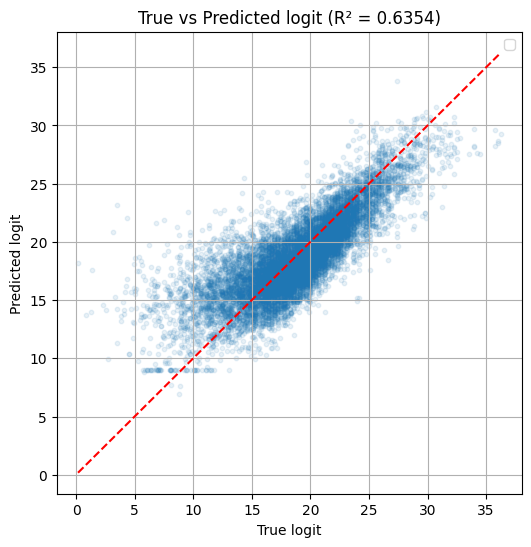

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create grid of subplots for each layer
n_cols = 4
n_rows = int(np.ceil(n_layers / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_layers > 1 else [axes]

for layer in range(n_layers):
    ax = axes[layer]
    
    # Set LAYER global for get_losses_and_acts
    LAYER = layer
    
    # Get test data
    test_batch_texts = data_test[:BATCH_SIZE]['text']
    test_losses, test_acts = get_losses_and_acts(model, test_batch_texts)
    
    if len(test_losses) > 0:
        # Make predictions
        predictor = predictors[layer]
        predicted_losses = predictor.predict(test_acts)
        
        # Flatten and filter valid tokens
        test_losses_flat = test_losses.reshape(-1).float()
        predicted_losses_flat = predicted_losses.reshape(-1)
        valid_mask = test_losses_flat > 0.01
        test_losses_valid = test_losses_flat[valid_mask]
        predicted_losses_valid = predicted_losses_flat[valid_mask]
        
        if len(test_losses_valid) > 0:
            # Plot
            ax.scatter(test_losses_valid.cpu().numpy(), predicted_losses_valid.cpu().numpy(), 
                      alpha=0.3, s=5)
            
            # Add ideal line
            min_val = min(test_losses_valid.min().item(), predicted_losses_valid.min().item())
            max_val = max(test_losses_valid.max().item(), predicted_losses_valid.max().item())
            ax.plot([min_val, max_val], [min_val, max_val], 
                   color='red', linestyle='--', linewidth=1)
            
            ax.set_xlabel(f"True {LOSS_TYPE}", fontsize=8)
            ax.set_ylabel(f"Predicted {LOSS_TYPE}", fontsize=8)
            ax.set_title(f"Layer {layer} (R²={r2_scores[layer]:.3f})", fontsize=9)
            ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"Layer {layer}", fontsize=9)

# Hide unused subplots
for i in range(n_layers, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('layer_predictions.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# Plot R² vs layer
plt.figure(figsize=(10, 6))
layers = sorted(r2_scores.keys())
r2_values = [r2_scores[layer] for layer in layers]

plt.plot(layers, r2_values, marker='o', linewidth=2, markersize=6)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'R² Score vs Layer for {LOSS_TYPE} Prediction', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(layers)

# Add horizontal line at R²=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('r2_vs_layer.png', dpi=150, bbox_inches='tight')
plt.show()

# Print R² scores
print("\nR² scores by layer:")
for layer in layers:
    print(f"Layer {layer:2d}: R² = {r2_scores[layer]:.4f}")


In [74]:
logits = model("hi my name is Jaob")